In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/COS429/cv_final_project"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "archive")

print(os.listdir(DATASET_ROOT))

['Val', 'Test', 'Train']


# Training

##Step 1: Prepare Data (Convert XML to YOLO Format)
YOLO requires text files with normalized coordinates (class_id, x_center, y_center, width, height). Run this script once to convert your PnPLO dataset.

In [ ]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

OUTPUT_DIR = "./PnPLO_YOLO"       # where YOLO data will be saved
CLASSES = ["person-like", "person"] # 0: person-like, 1: person

def convert_xml_to_yolo(xml_file, output_txt, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(output_txt, 'w') as f:
        for obj in root.findall('object'):
            name = obj.find('name').text.lower().strip()
            if name not in CLASSES: continue

            cls_id = CLASSES.index(name)
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            # normalize
            x_center = ((xmin + xmax) / 2) / img_width
            y_center = ((ymin + ymax) / 2) / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

# create directories
for split in ['train', 'val', 'test']:
    os.makedirs(f"{OUTPUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/labels/{split}", exist_ok=True)

# pro
import shutil
import cv2

for split in ['train', 'val', 'test']:
    split_folder_name = split.capitalize()
    base_path = os.path.join(DATASET_ROOT, split_folder_name, split_folder_name)

    img_dir = os.path.join(base_path, "JPEGImages")
    ann_dir = os.path.join(base_path, "Annotations")
    list_file = os.path.join(base_path, f"{split}.txt")

    with open(list_file, 'r') as f:
        ids = [line.strip().replace('.jpg', '') for line in f if line.strip()]

    print(f"Processing {split}...")
    for img_id in tqdm(ids):
        src_img = os.path.join(img_dir, f"{img_id}.jpg")
        dst_img = os.path.join(OUTPUT_DIR, "images", split, f"{img_id}.jpg")

        if not os.path.exists(src_img): continue
        shutil.copy(src_img, dst_img)

        src_xml = os.path.join(ann_dir, f"{img_id}.xml")
        dst_txt = os.path.join(OUTPUT_DIR, "labels", split, f"{img_id}.txt")

        if os.path.exists(src_xml):
            img = cv2.imread(src_img)
            h, w = img.shape[:2]
            convert_xml_to_yolo(src_xml, dst_txt, w, h)

yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: images/train
val: images/val
test: images/test

names:
  0: person-like
  1: person
"""
with open(f"{OUTPUT_DIR}/data.yaml", 'w') as f:
    f.write(yaml_content)

print("Data conversion complete.")

Processing train...


100%|██████████| 944/944 [00:16<00:00, 56.81it/s]


Processing val...


100%|██████████| 160/160 [00:02<00:00, 58.50it/s]


Processing test...


100%|██████████| 235/235 [00:03<00:00, 62.10it/s]

Data conversion complete.


##Step 2: Train the Detector (YOLOv11)
We use ultralytics because it is fast, accurate, and easy to integrate with PyTorch.

In [ ]:
!pip install ultralytics

from ultralytics import YOLO

# load a pre-trained model (Transfer Learning)
model = YOLO('yolo11n.pt')

# train the model
results = model.train(
    data=f"{OUTPUT_DIR}/data.yaml",
    epochs=20,           # Adjust based on your time
    imgsz=640,           # Standard image size
    batch=16,
    name='pnplo_detector'
)

metrics = model.val(plots=True)
print("Map50:", metrics.box.map50)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./PnPLO_YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pnplo_detector4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

## Step 3: The "Det-SAM" Inference Loop (Combine Both)
Run YOLO to find boxes, then pass those boxes to SAM 2.

### Clone SAM2 repo (from GitHub)

In [ ]:
!nvidia-smi


!pip install --upgrade pip
!pip install "torch==2.5.1" "torchvision==0.20.1" --index-url https://download.pytorch.org/whl/cu121


!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e .
!pip install -e ".[notebooks]"


%cd checkpoints
!bash download_ckpts.sh
%cd ..

Tue Dec  9 08:26:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   69C    P0             33W /   72W |    1281MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

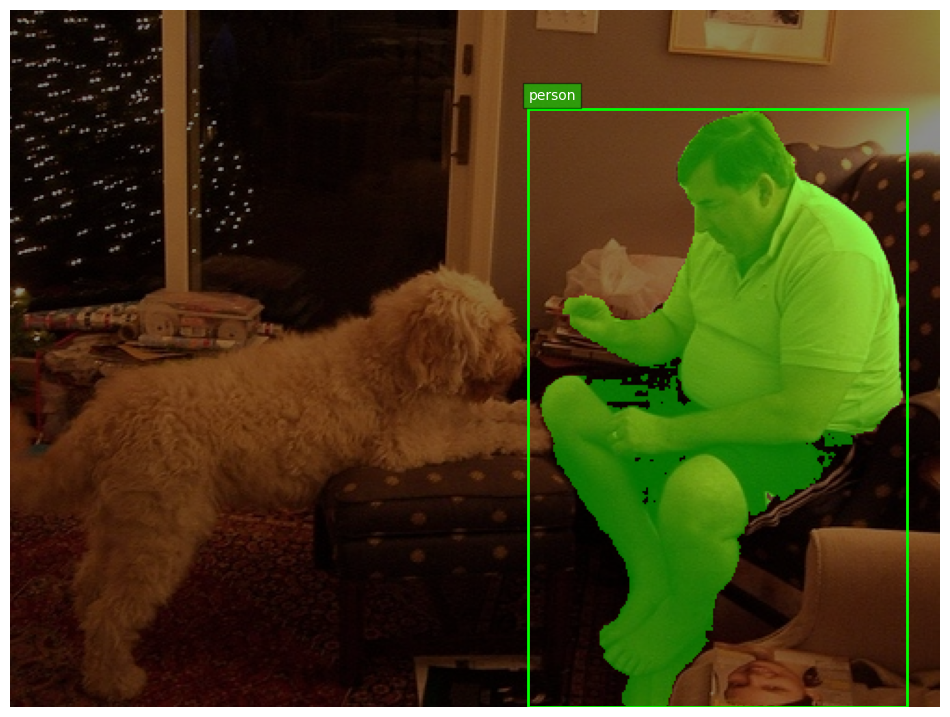

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda" if torch.cuda.is_available() else "cpu"

yolo_model = YOLO("/content/runs/detect/pnplo_detector2/weights/best.pt")

sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

# inference
def run_det_sam(image_path):

    image = cv2.imread(image_path)
    if image is None: return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_rgb, conf=0.5, verbose=False)[0]

    boxes = results.boxes.xyxy.cpu().numpy() # [x1, y1, x2, y2]
    class_ids = results.boxes.cls.cpu().numpy().astype(int)
    class_names = results.names

    if len(boxes) == 0:
        print("No objects detected.")
        return

    sam2_predictor.set_image(image_rgb)

    input_boxes = boxes

    masks, scores, _ = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False
    )


    plt.figure(figsize=(12, 12))
    plt.imshow(image_rgb)
    ax = plt.gca()

    for i, (box, mask, cls_id) in enumerate(zip(boxes, masks, class_ids)):
        x1, y1, x2, y2 = box
        label = class_names[cls_id]

        color = (0, 1, 0) if label == 'person' else (1, 0, 0)


        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, label, color='white', bbox=dict(facecolor=color, alpha=0.5))

        show_mask(mask.squeeze(), ax, color=color)

    plt.axis('off')
    plt.show()

def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, 3)
    ax.imshow(mask_image, alpha=0.45)

# view image
test_image_path = DATASET_ROOT + "/Test/Test/JPEGImages/image (77).jpg" # Adjust path
run_det_sam(test_image_path)

# Evaluation

/content
Running evaluation on Test set...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2194.8±507.7 MB/s, size: 100.7 KB)
val: Scanning /content/PnPLO_YOLO/labels/test.cache... 235 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 235/235 458.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 5.9it/s 2.5s
                   all        235        595      0.788      0.788      0.848      0.567
           person-like        110        278      0.822      0.781       0.86      0.612
                person        157        317      0.754      0.795      0.836      0.521
Speed: 1.1ms preprocess, 3.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/pnplo_eval5

--- Evaluation Results ---
mAP@50 (Mean Ave

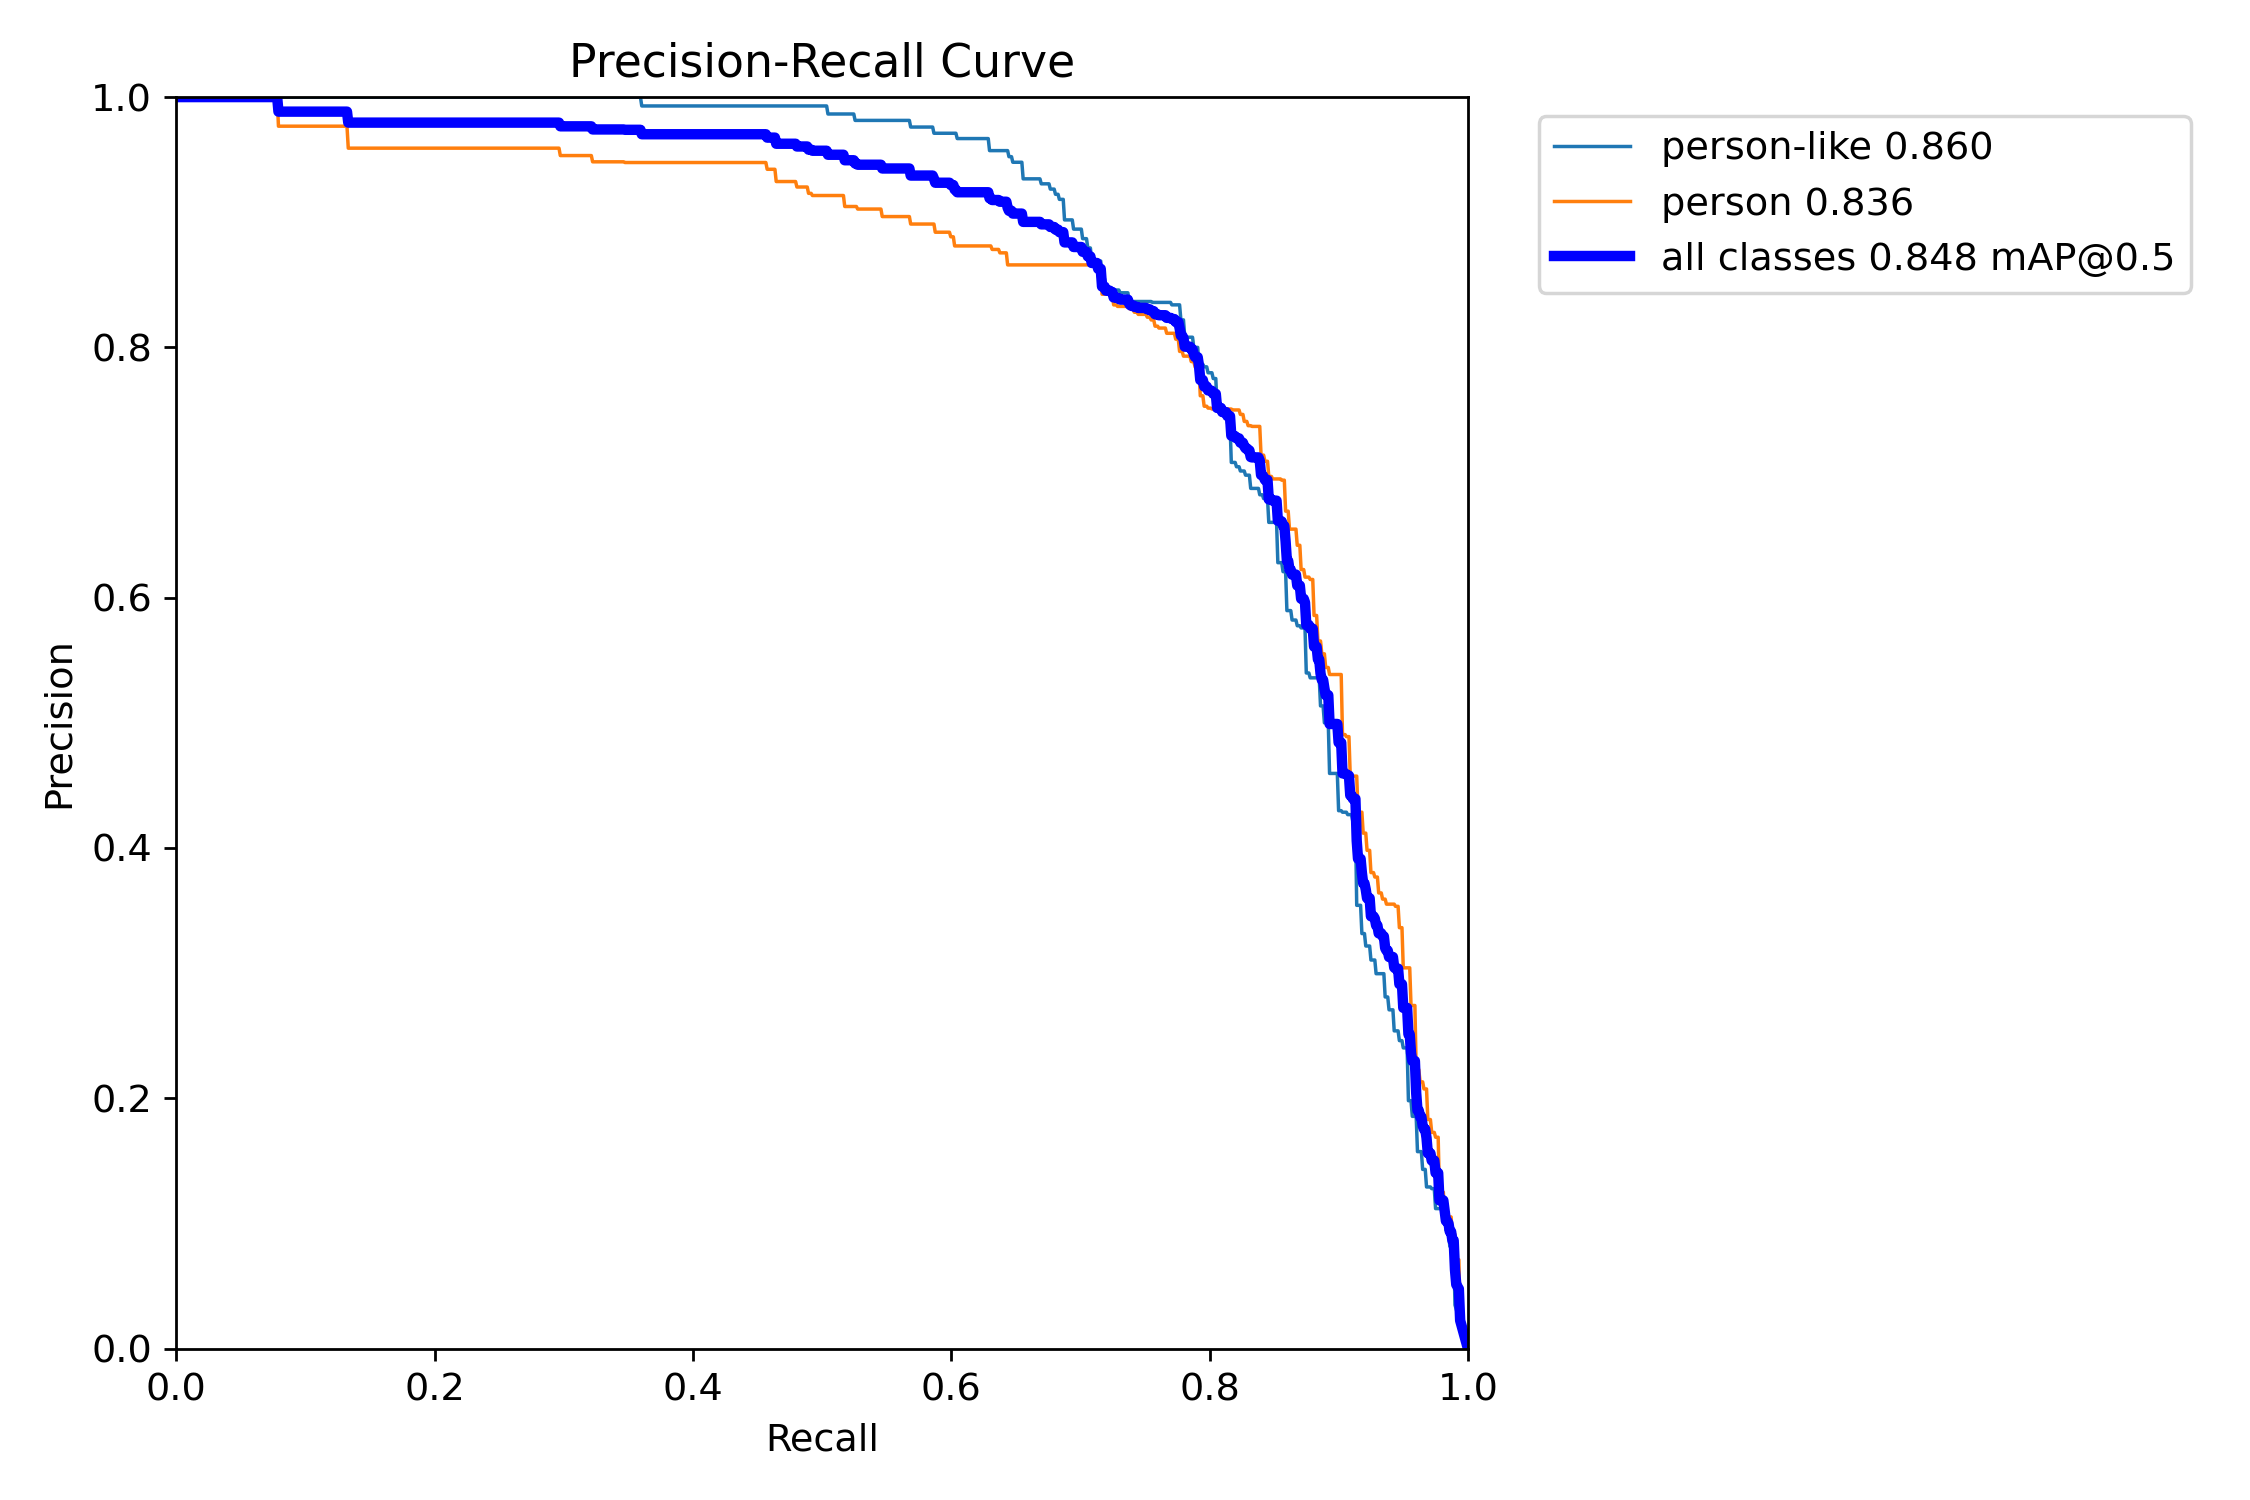


2. Confusion Matrix


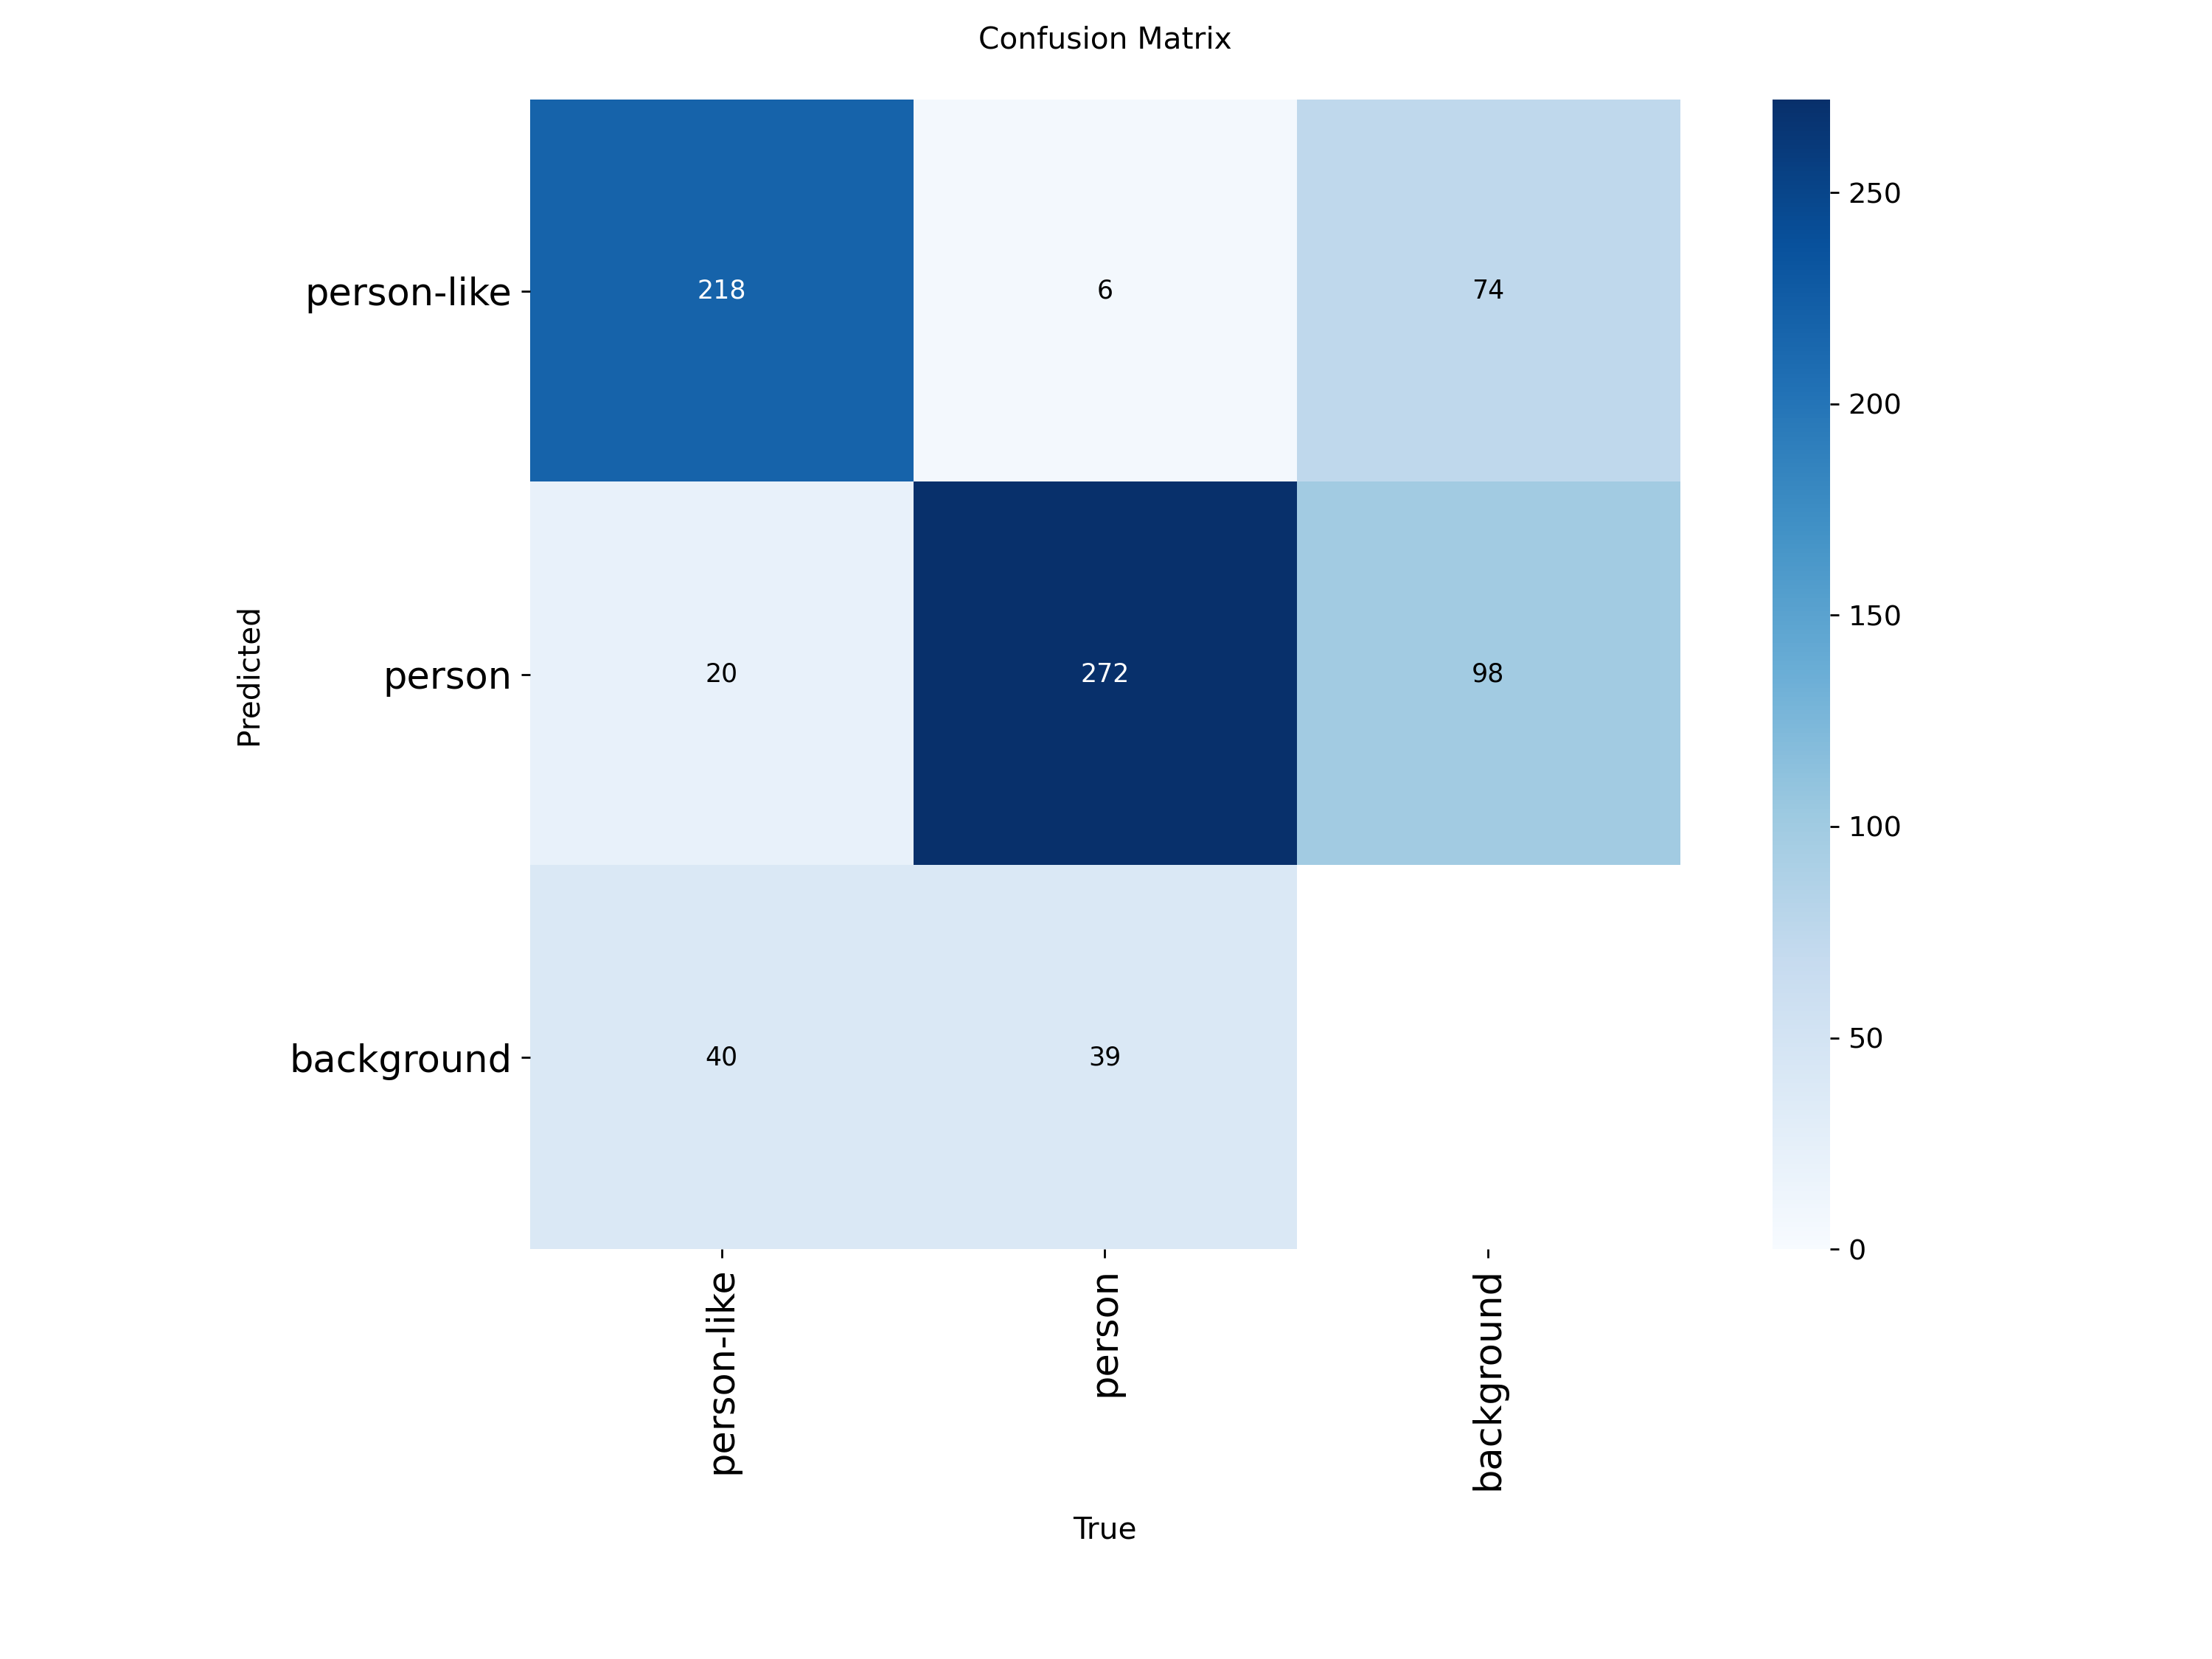


3. F1 Score Curve


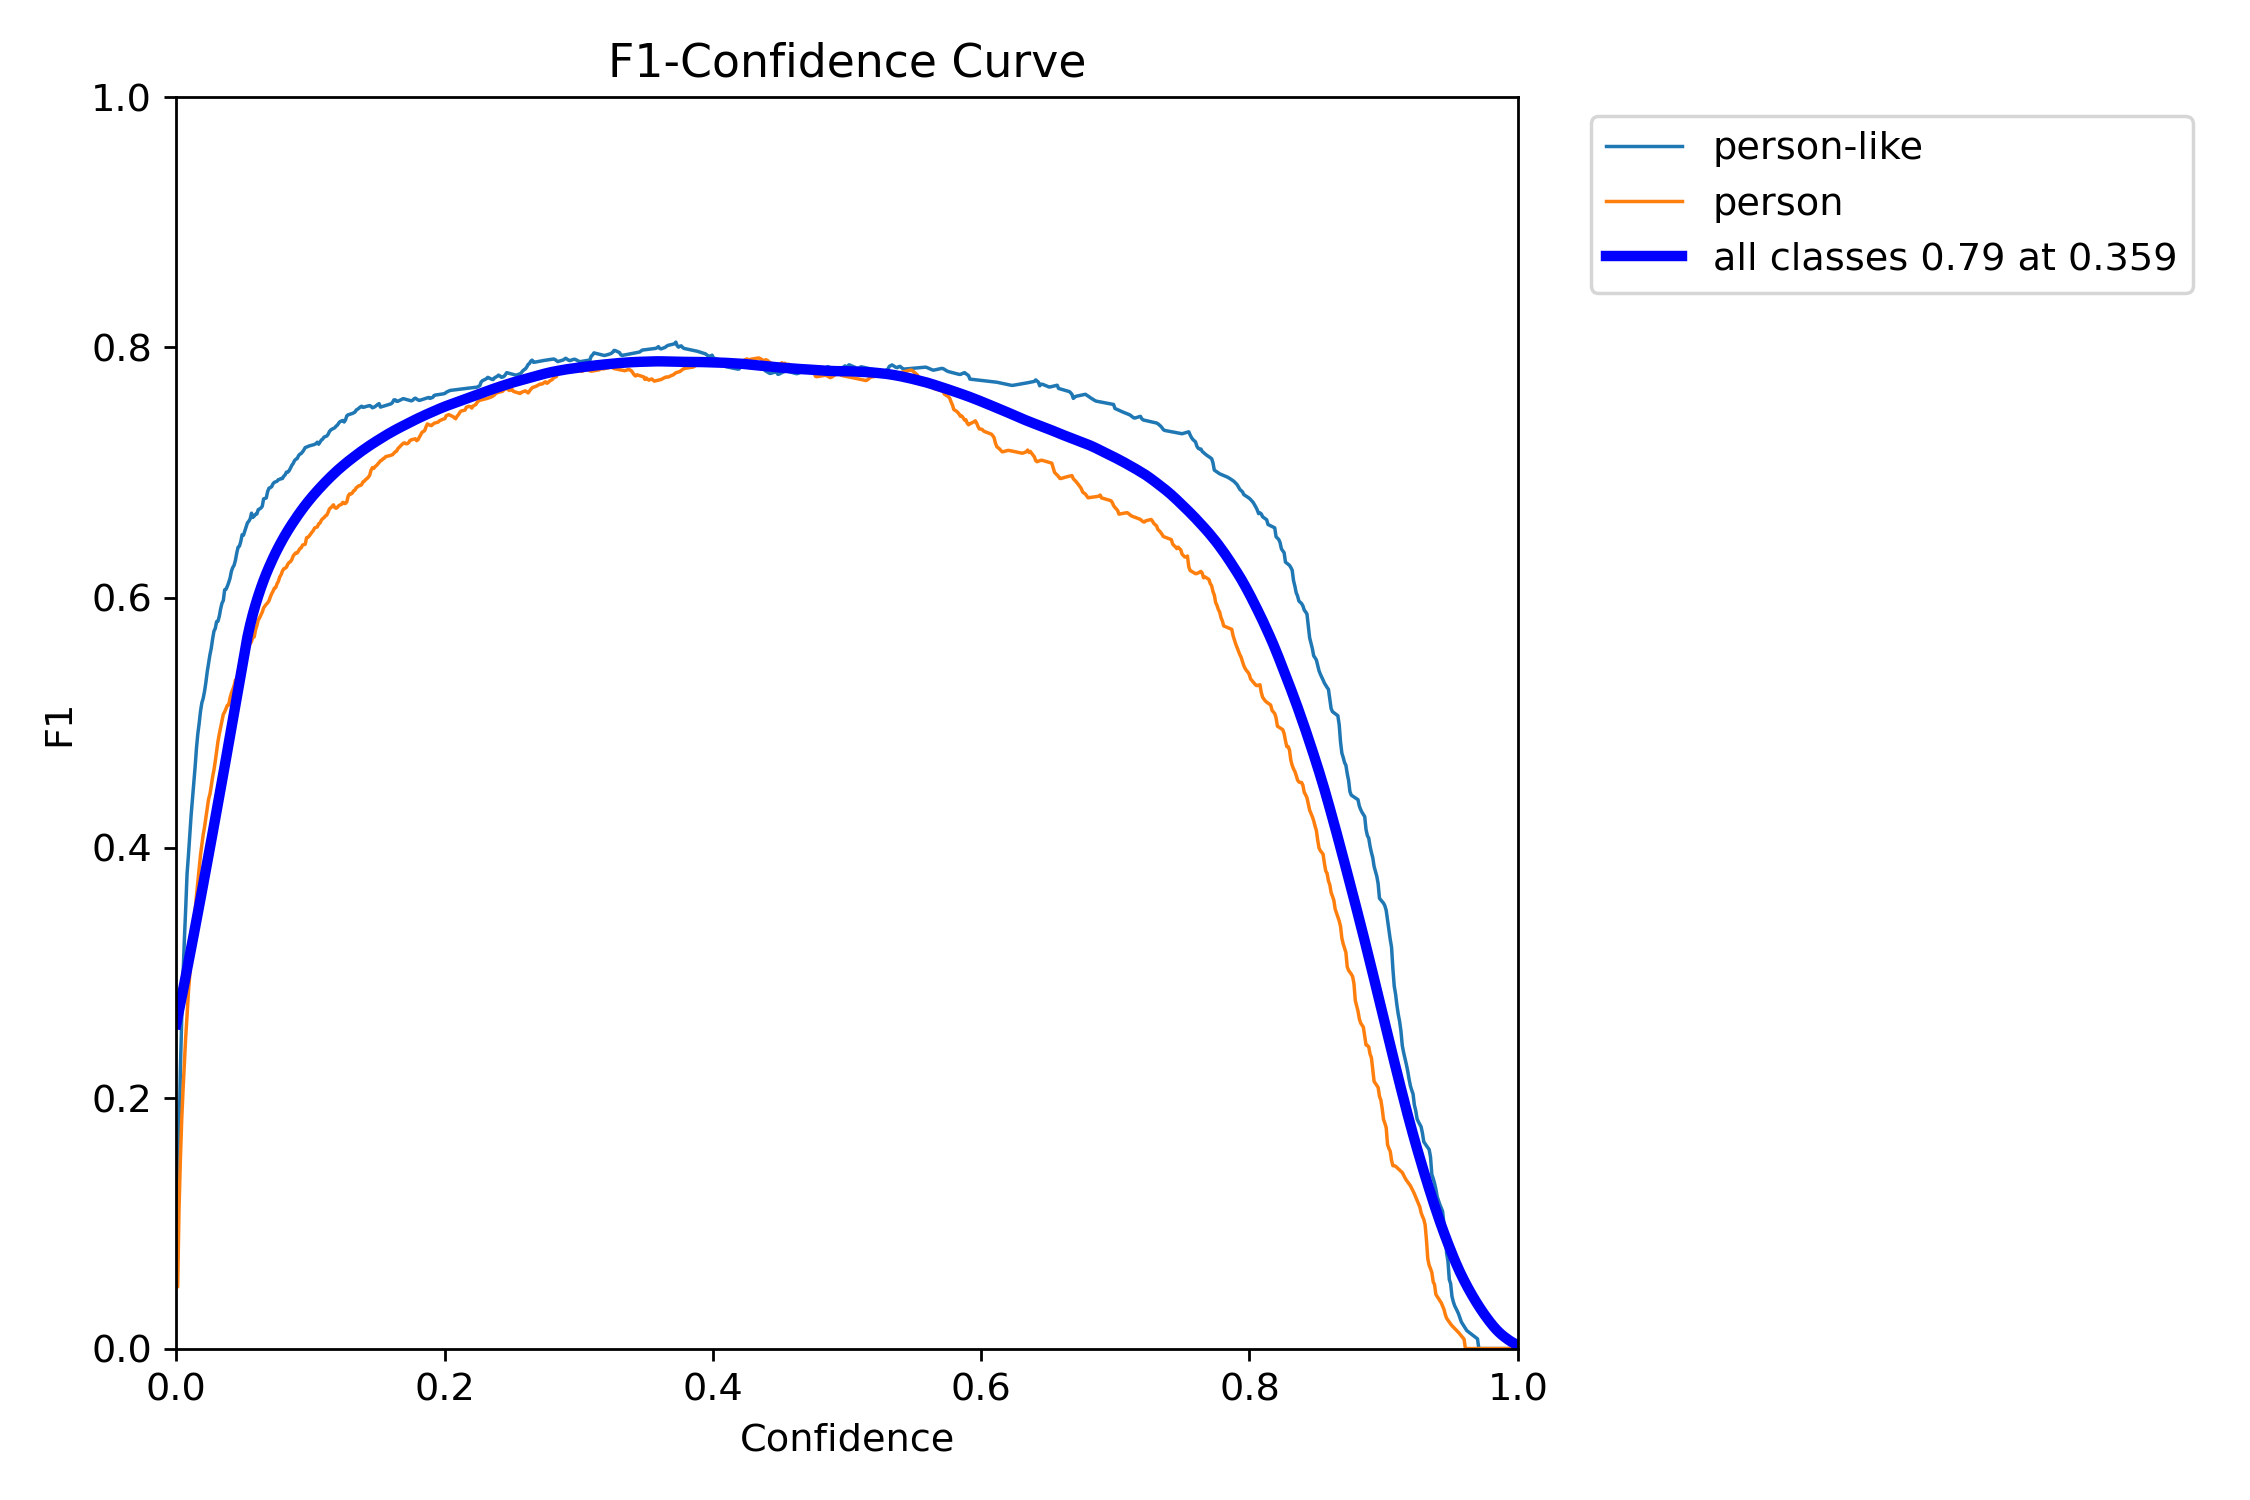

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display

%cd /content


model = YOLO("/content/runs/detect/pnplo_detector2/weights/best.pt")



print("Running evaluation on Test set...")
metrics = model.val(
    data="/content/PnPLO_YOLO/data.yaml",
    split="test",
    project="/content/runs/detect",
    name="pnplo_eval",
    plots=True
)


print("\n--- Evaluation Results ---")
print(f"mAP@50 (Mean Average Precision at 0.5 IoU): {metrics.box.map50:.4f}")
print(f"mAP@50-95 (Strict Average Precision):      {metrics.box.map:.4f}")
print(f"Precision (Mean):                          {metrics.box.mp:.4f}")
print(f"Recall (Mean):                             {metrics.box.mr:.4f}")

# Per-Class Metrics
print("\n--- Per Class Metrics ---")

for i, class_idx in enumerate(metrics.box.ap_class_index):
    class_name = metrics.names[class_idx]
    ap50 = metrics.box.ap50[i]
    print(f"Class: {class_name:<12} | AP@50: {ap50:.4f}")

# display Generated Plots
save_dir = metrics.save_dir

print(f"\nPlots saved in: {save_dir}")

print("\n1. Precision-Recall Curve")
display(Image(filename=os.path.join(save_dir, 'BoxPR_curve.png')))

print("\n2. Confusion Matrix")
display(Image(filename=os.path.join(save_dir, 'confusion_matrix.png')))

print("\n3. F1 Score Curve")
display(Image(filename=os.path.join(save_dir, 'BoxF1_curve.png')))

## Visuaize a few examples
The bottom cells do the same thing, so repetition, but the purpose is to visiualize the predictions

Loading models on cuda...
Found 235 test images. Showing 4 examples...


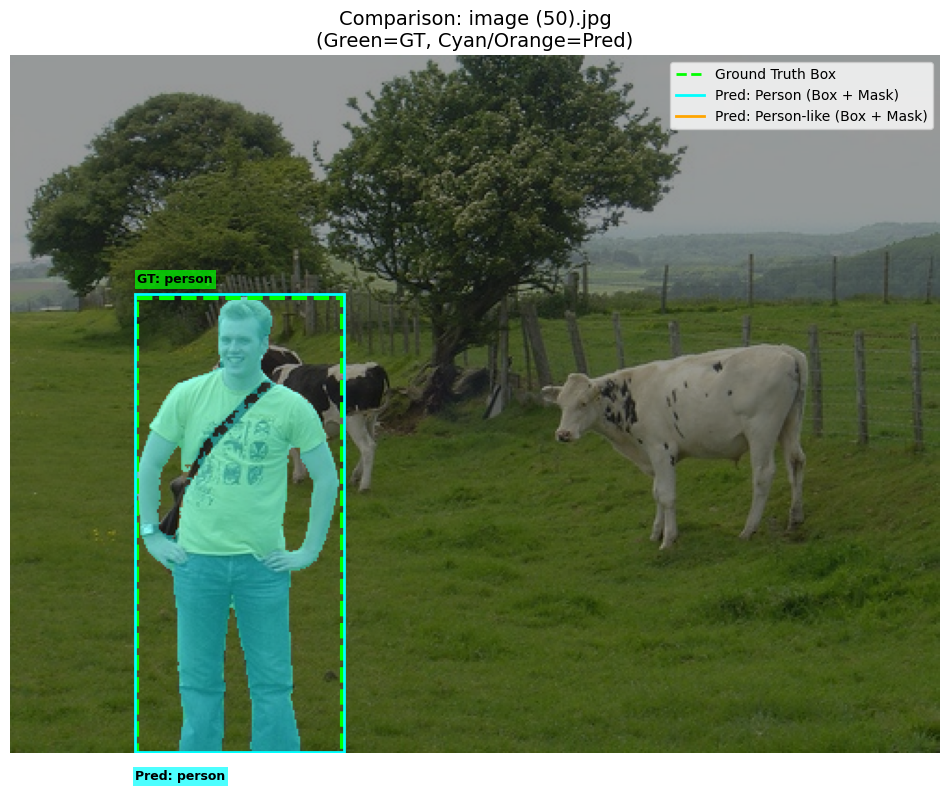

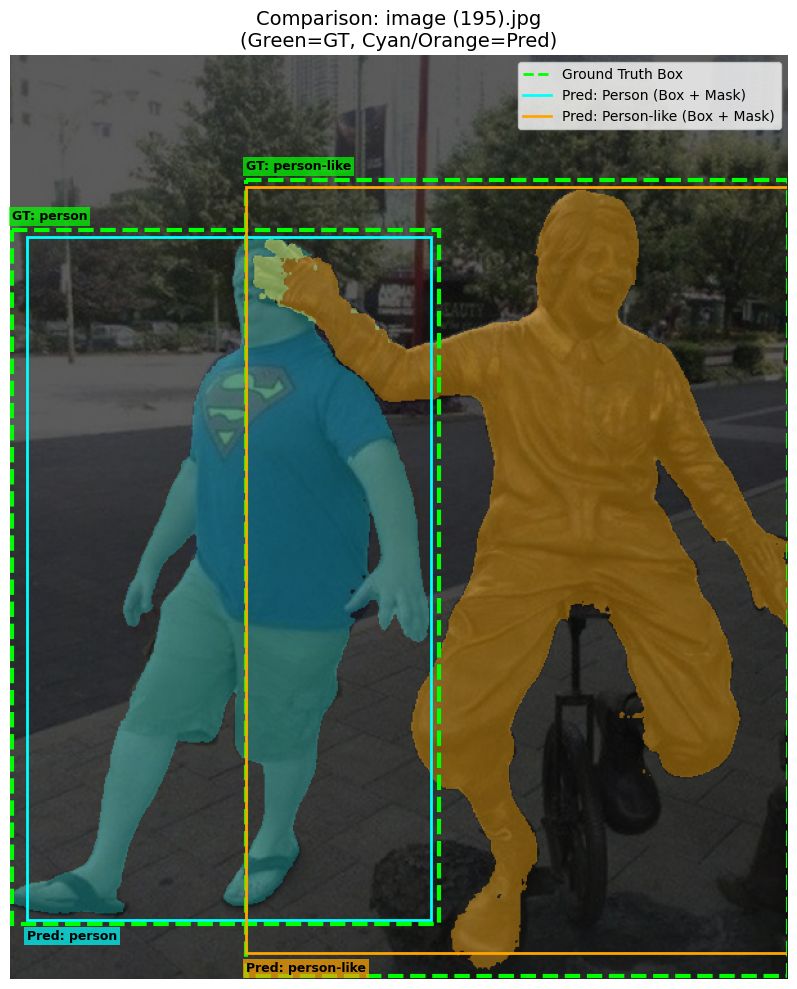

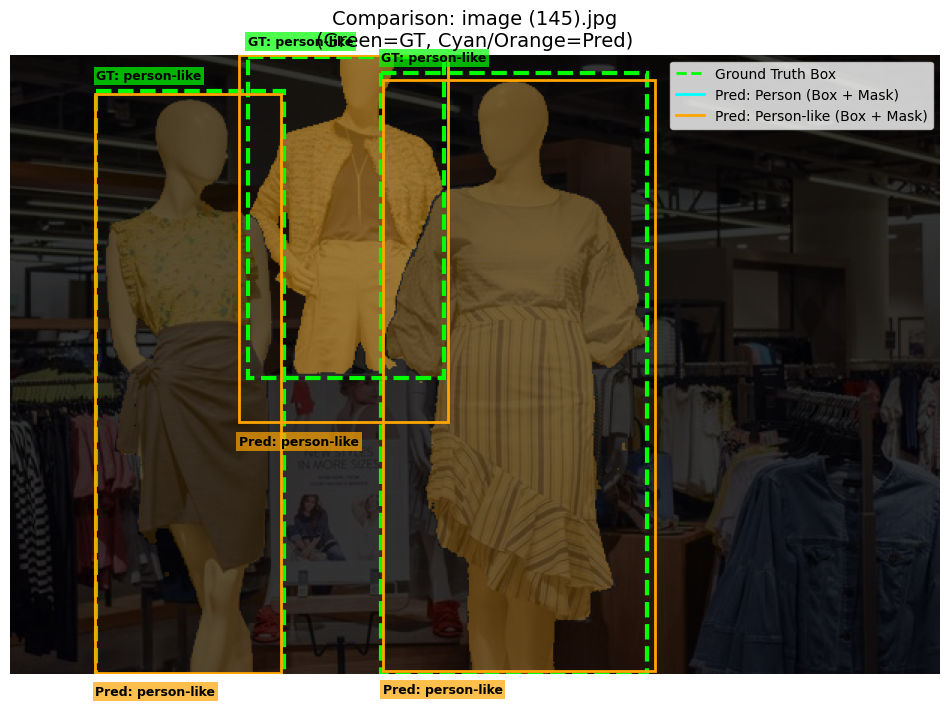

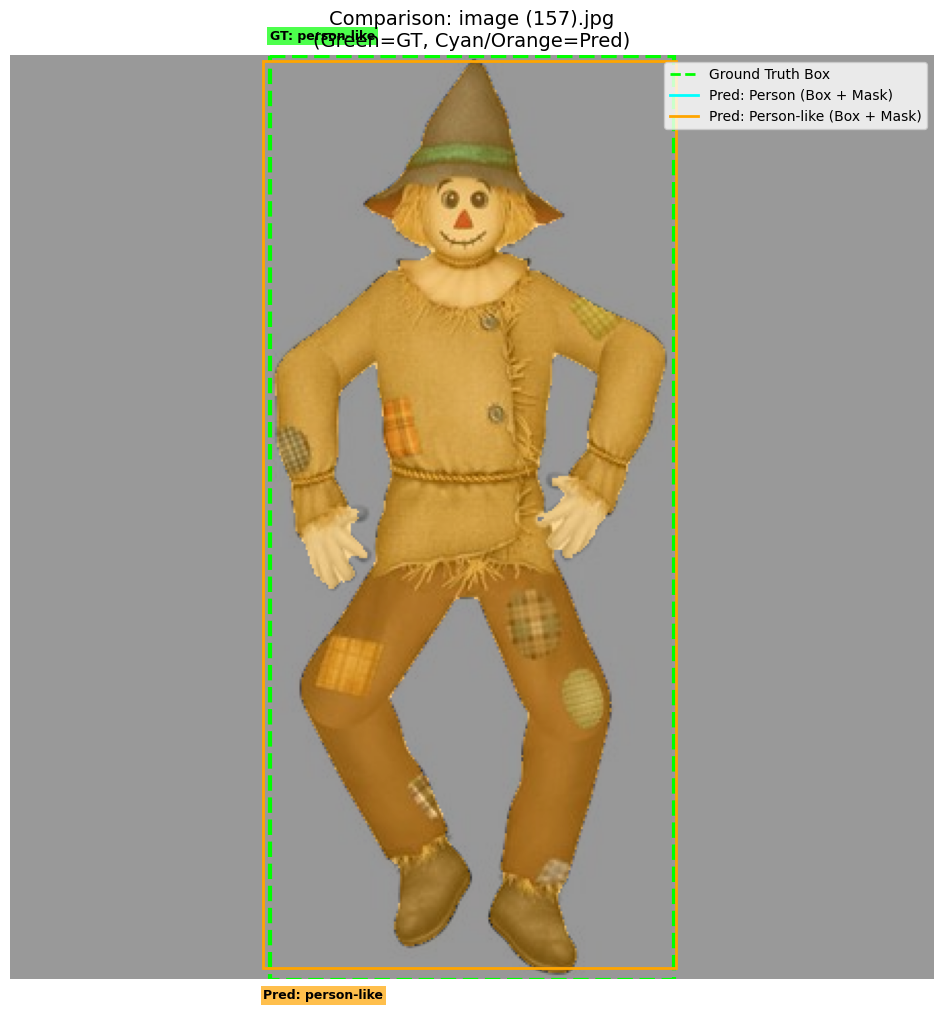

In [ ]:
import os
import cv2
import glob
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

TEST_IMAGES_DIR = "./PnPLO_YOLO/images/test"
TEST_LABELS_DIR = "./PnPLO_YOLO/labels/test"
YOLO_MODEL_PATH = "/content/runs/detect/pnplo_detector2/weights/best.pt"
SAM2_CHECKPOINT = "/content/sam2/checkpoints/sam2.1_hiera_tiny.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_t.yaml"
CLASSES = {0: 'person-like', 1: 'person'}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading models on {device}...")


yolo_model = YOLO(YOLO_MODEL_PATH)

sam2_model = build_sam2(SAM2_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

def get_ground_truth(image_path):
    """Reads the YOLO format .txt file and converts back to pixel coordinates."""
    img_name = os.path.basename(image_path).replace('.jpg', '.txt')
    label_path = os.path.join(TEST_LABELS_DIR, img_name)

    boxes = []
    class_ids = []

    if not os.path.exists(label_path):
        return [], []


    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])

            # convert normalized xywh to pixel xyxy
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)

            boxes.append([x1, y1, x2, y2])
            class_ids.append(cls_id)

    return boxes, class_ids

def get_predictions(image_path):

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = yolo_model(img_rgb, conf=0.25, verbose=False)[0]
    pred_boxes = results.boxes.xyxy.cpu().numpy()
    pred_classes = results.boxes.cls.cpu().numpy().astype(int)

    if len(pred_boxes) == 0:
        return [], [], []


    sam2_predictor.set_image(img_rgb)
    masks, _, _ = sam2_predictor.predict(box=pred_boxes, multimask_output=False)

    # squeeze masks (N, 1, H, W) -> (N, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    return pred_boxes, pred_classes, masks

def plot_comparison(image_path):


    gt_boxes, gt_classes = get_ground_truth(image_path)
    pred_boxes, pred_classes, pred_masks = get_predictions(image_path)

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_rgb)

    found_gt = False
    for box, cls_id in zip(gt_boxes, gt_classes):
        found_gt = True
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), w, h, linewidth=3, edgecolor='#00FF00', facecolor='none', linestyle='--')
        ax.add_patch(rect)

        label_text = f"GT: {CLASSES[cls_id]}"
        ax.text(x1, y1 - 8, label_text, color='black', fontsize=9, fontweight='bold',
                bbox=dict(facecolor='#00FF00', alpha=0.7, edgecolor='none', pad=2))

    # colors for predictions: Person = Cyan, Person-Like = Orange
    PRED_COLORS = {1: '#00FFFF', 0: '#FFA500'}

    for i, (box, cls_id) in enumerate(zip(pred_boxes, pred_classes)):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color = PRED_COLORS.get(cls_id, 'red')

        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none', linestyle='-')
        ax.add_patch(rect)

        label_text = f"Pred: {CLASSES[cls_id]}"
        ax.text(x1, y2 + 15, label_text, color='black', fontsize=9, fontweight='bold',
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2))

        # overlay Mask
        if i < len(pred_masks):
            mask = pred_masks[i]
            color_rgb = np.array([int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)])
            colored_mask = np.zeros_like(img_rgb)
            colored_mask[mask > 0] = color_rgb
            ax.imshow(colored_mask, alpha=0.4)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#00FF00', lw=2, linestyle='--', label='Ground Truth Box'),
        Line2D([0], [0], color='#00FFFF', lw=2, label='Pred: Person (Box + Mask)'),
        Line2D([0], [0], color='#FFA500', lw=2, label='Pred: Person-like (Box + Mask)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.title(f"Comparison: {os.path.basename(image_path)}\n(Green=GT, Cyan/Orange=Pred)", fontsize=14)
    plt.axis('off')
    plt.show()


all_test_images = glob.glob(os.path.join(TEST_IMAGES_DIR, "*.jpg"))

if not all_test_images:
    print("No images found! Check TEST_IMAGES_DIR path.")
else:
    random.shuffle(all_test_images)
    print(f"Found {len(all_test_images)} test images. Showing 4 examples...")

    for img_path in all_test_images[:4]:
        try:
            plot_comparison(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

Below is the same cell as above, was used for debugging and to visualize more examples.

Loading models on cuda...
Found 235 test images. Showing 4 examples...


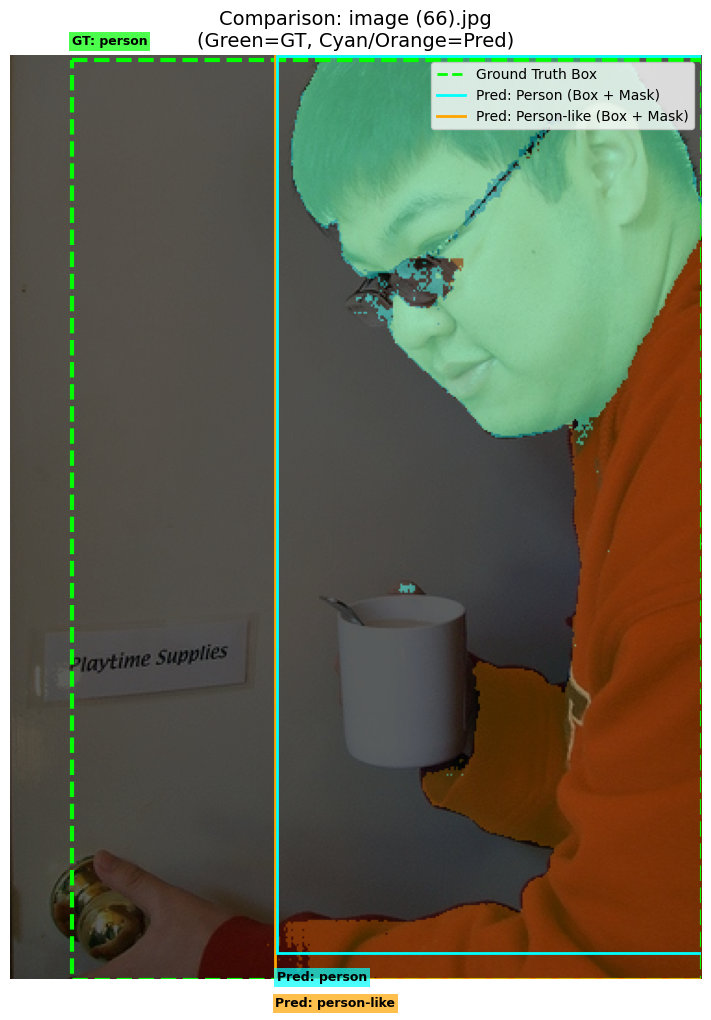

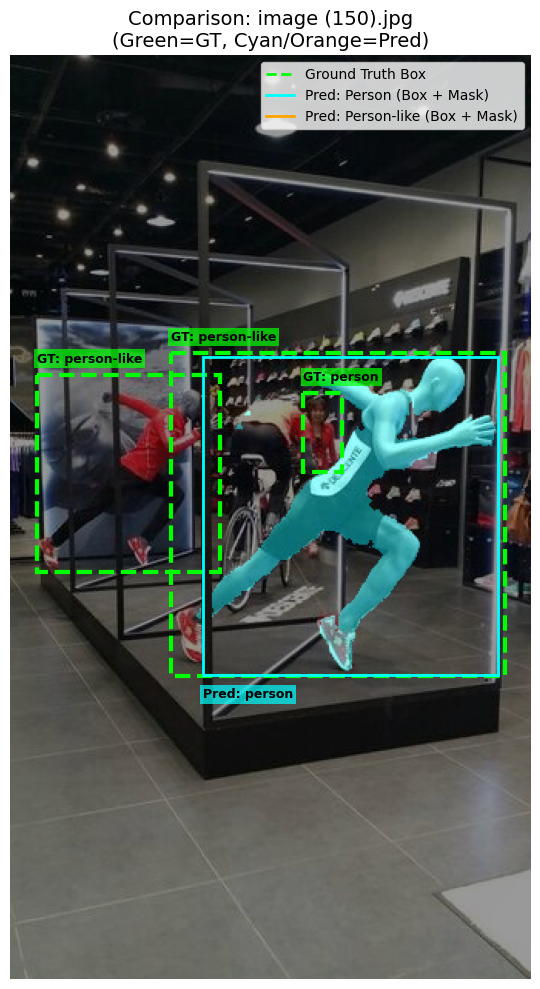

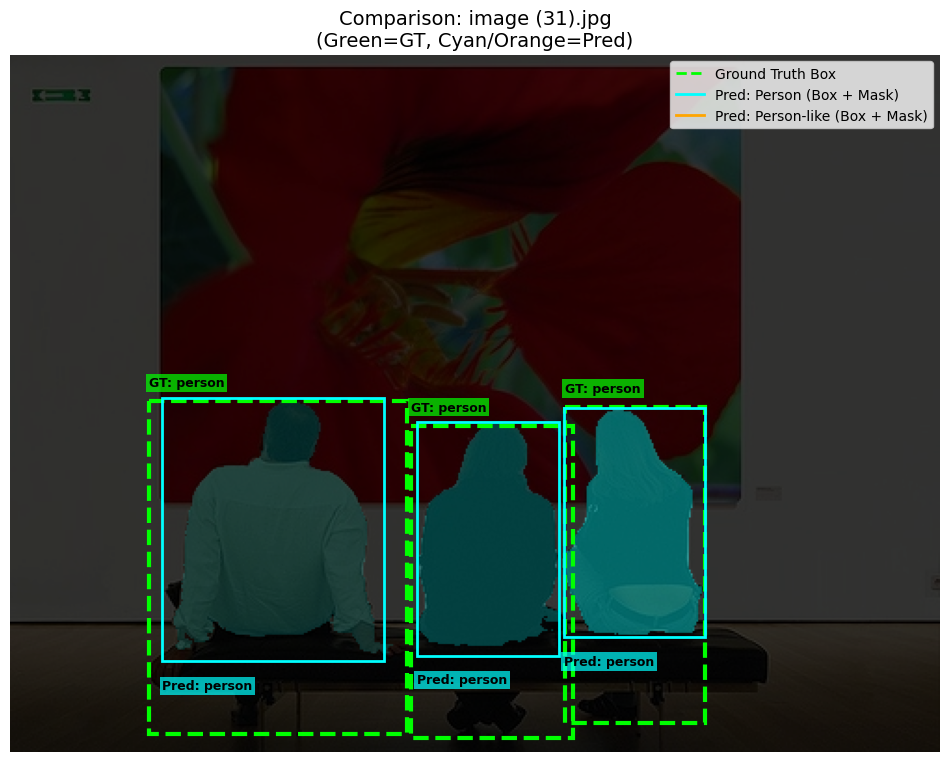

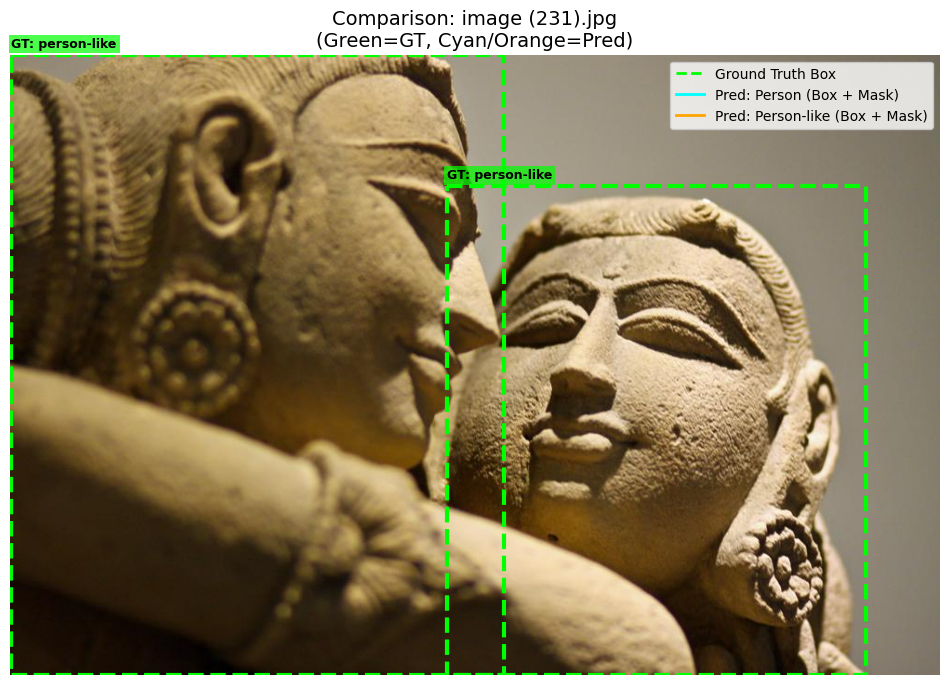

In [ ]:
import os
import cv2
import glob
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

TEST_IMAGES_DIR = "./PnPLO_YOLO/images/test"
TEST_LABELS_DIR = "./PnPLO_YOLO/labels/test"
YOLO_MODEL_PATH = "/content/runs/detect/pnplo_detector2/weights/best.pt"
SAM2_CHECKPOINT = "/content/sam2/checkpoints/sam2.1_hiera_tiny.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_t.yaml"
CLASSES = {0: 'person-like', 1: 'person'}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading models on {device}...")


yolo_model = YOLO(YOLO_MODEL_PATH)

sam2_model = build_sam2(SAM2_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

def get_ground_truth(image_path):
    """Reads the YOLO format .txt file and converts back to pixel coordinates."""
    img_name = os.path.basename(image_path).replace('.jpg', '.txt')
    label_path = os.path.join(TEST_LABELS_DIR, img_name)

    boxes = []
    class_ids = []

    if not os.path.exists(label_path):
        return [], []


    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])

            # convert normalized xywh to pixel xyxy
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)

            boxes.append([x1, y1, x2, y2])
            class_ids.append(cls_id)

    return boxes, class_ids

def get_predictions(image_path):

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = yolo_model(img_rgb, conf=0.25, verbose=False)[0]
    pred_boxes = results.boxes.xyxy.cpu().numpy()
    pred_classes = results.boxes.cls.cpu().numpy().astype(int)

    if len(pred_boxes) == 0:
        return [], [], []


    sam2_predictor.set_image(img_rgb)
    masks, _, _ = sam2_predictor.predict(box=pred_boxes, multimask_output=False)

    # squeeze masks (N, 1, H, W) -> (N, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    return pred_boxes, pred_classes, masks

def plot_comparison(image_path):


    gt_boxes, gt_classes = get_ground_truth(image_path)
    pred_boxes, pred_classes, pred_masks = get_predictions(image_path)

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_rgb)

    found_gt = False
    for box, cls_id in zip(gt_boxes, gt_classes):
        found_gt = True
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), w, h, linewidth=3, edgecolor='#00FF00', facecolor='none', linestyle='--')
        ax.add_patch(rect)

        label_text = f"GT: {CLASSES[cls_id]}"
        ax.text(x1, y1 - 8, label_text, color='black', fontsize=9, fontweight='bold',
                bbox=dict(facecolor='#00FF00', alpha=0.7, edgecolor='none', pad=2))

    # colors for predictions: Person = Cyan, Person-Like = Orange
    PRED_COLORS = {1: '#00FFFF', 0: '#FFA500'}

    for i, (box, cls_id) in enumerate(zip(pred_boxes, pred_classes)):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color = PRED_COLORS.get(cls_id, 'red')

        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none', linestyle='-')
        ax.add_patch(rect)

        label_text = f"Pred: {CLASSES[cls_id]}"
        ax.text(x1, y2 + 15, label_text, color='black', fontsize=9, fontweight='bold',
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2))

        # overlay Mask
        if i < len(pred_masks):
            mask = pred_masks[i]
            color_rgb = np.array([int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)])
            colored_mask = np.zeros_like(img_rgb)
            colored_mask[mask > 0] = color_rgb
            ax.imshow(colored_mask, alpha=0.4)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#00FF00', lw=2, linestyle='--', label='Ground Truth Box'),
        Line2D([0], [0], color='#00FFFF', lw=2, label='Pred: Person (Box + Mask)'),
        Line2D([0], [0], color='#FFA500', lw=2, label='Pred: Person-like (Box + Mask)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.title(f"Comparison: {os.path.basename(image_path)}\n(Green=GT, Cyan/Orange=Pred)", fontsize=14)
    plt.axis('off')
    plt.show()


all_test_images = glob.glob(os.path.join(TEST_IMAGES_DIR, "*.jpg"))

if not all_test_images:
    print("No images found! Check TEST_IMAGES_DIR path.")
else:
    random.shuffle(all_test_images)
    print(f"Found {len(all_test_images)} test images. Showing 4 examples...")

    for img_path in all_test_images[:4]:
        try:
            plot_comparison(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

## Plot the histogram of the predicted probabilities from the SAM2 binary classification model on the test set

YOLO Model loaded successfully.
Running inference on test set to collect probabilities...
Histogram saved successfully to: results_yolo/yolo_probability_histogram.png


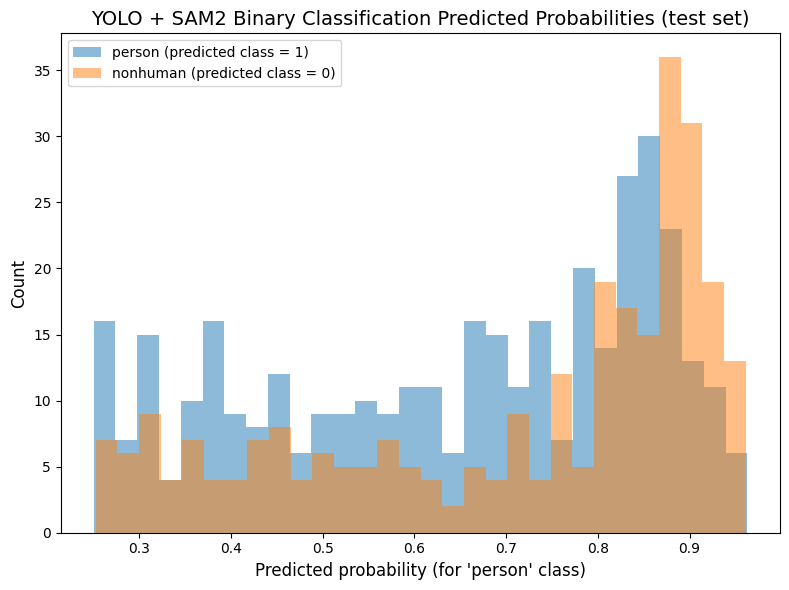

Histogram of predicted probabilities for YOLO binary classification model generated and saved.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from ultralytics import YOLO

TEST_IMAGES_DIR = "./PnPLO_YOLO/images/test"
RESULTS_DIR = "results_yolo"
os.makedirs(RESULTS_DIR, exist_ok=True)

model_path = "/content/runs/detect/pnplo_detector2/weights/best.pt"

if not os.path.exists(model_path):
    print(f"Error: Model not found at {model_path}")
else:
    model = YOLO(model_path)
    print("YOLO Model loaded successfully.")


    person_confidences = []      # Class 1
    person_like_confidences = [] # Class 0

    print("Running inference on test set to collect probabilities...")
    test_images = glob.glob(os.path.join(TEST_IMAGES_DIR, "*.jpg"))

    for img_path in test_images:
        # Run inference

        results = model(img_path, verbose=False)[0]


        boxes = results.boxes
        if len(boxes) > 0:
            confidences = boxes.conf.cpu().numpy()
            class_ids = boxes.cls.cpu().numpy().astype(int)

            for score, cls_id in zip(confidences, class_ids):
                if cls_id == 1: # Person
                    person_confidences.append(score)
                elif cls_id == 0: # Person-Like
                    person_like_confidences.append(score)


    plt.figure(figsize=(8, 6))

    plt.hist(
        np.array(person_confidences),
        bins=30,
        alpha=0.5,
        label="person (predicted class = 1)"
    )

    plt.hist(
        np.array(person_like_confidences),
        bins=30,
        alpha=0.5,
        label="nonhuman (predicted class = 0)"
    )

    plt.xlabel("Predicted probability (for 'person' class)", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title("YOLO + SAM2 Binary Classification Predicted Probabilities (test set)", fontsize=14)

    plt.legend()
    plt.tight_layout()

    save_path = os.path.join(RESULTS_DIR, "yolo_probability_histogram.png")
    plt.savefig(save_path, dpi=200)
    print(f"Histogram saved successfully to: {save_path}")

    plt.show()
    print("Histogram of predicted probabilities for YOLO binary classification model generated and saved.")


## Getting False Positive Rates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import os

MODEL_PATH = "/content/runs/detect/pnplo_detector2/weights/best.pt"
DATA_YAML = "PnPLO_YOLO/data.yaml"

def calculate_and_display_fpr(model_path, data_yaml):
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return

    model = YOLO(model_path)

    print("Running validation to calculate FPR...")

    metrics = model.val(data=data_yaml, split="test", plots=True, verbose=False)


    cm = metrics.confusion_matrix.matrix

    print("\n" + "="*50)
    print("DETAILED ERROR ANALYSIS")
    print("="*50)
    print(f"Raw Confusion Matrix:\n{cm}")

    tp_person = cm[1, 1]     # True Person -> Pred Person
    fp_misclass = cm[0, 1]   # True Statue -> Pred Person
    fp_ghost = cm[2, 1]      # Background -> Pred Person
    total_fp_person = fp_misclass + fp_ghost

    print(f"\n--- CLASS: PERSON (Target) ---")
    print(f"Total Correct Predictions (TP):      {int(tp_person)}")
    print(f"Total False Positives (FP):          {int(total_fp_person)}")
    print(f"  > From Statues (Misclassification): {int(fp_misclass)}")
    print(f"  > From Empty Space (Ghosts):        {int(fp_ghost)}")

    # calculate False Positive Rate / False Discovery Rate
    if (tp_person + total_fp_person) > 0:
        precision = tp_person / (tp_person + total_fp_person)
        fdr = 1 - precision
        print(f"\nFalse Discovery Rate (FDR): {fdr:.2%} (Lower is better)")
        print(f"Precision:                  {precision:.2%} (Higher is better)")
    else:
        print("No predictions made for Person class.")

    tp_pl = cm[0, 0]
    fp_misclass_pl = cm[1, 0] # True Person -> Pred Statue
    fp_ghost_pl = cm[2, 0]    # Background -> Pred Statue
    total_fp_pl = fp_misclass_pl + fp_ghost_pl

    print(f"\n--- CLASS: PERSON-LIKE (Target) ---")
    print(f"Total Correct Predictions (TP):      {int(tp_pl)}")
    print(f"Total False Positives (FP):          {int(total_fp_pl)}")
    print(f"  > From Real People (Misclassification): {int(fp_misclass_pl)}")
    print(f"  > From Empty Space (Ghosts):            {int(fp_ghost_pl)}")

# Run the function
calculate_and_display_fpr(MODEL_PATH, DATA_YAML)

Running validation to calculate FPR...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2440.3±1339.0 MB/s, size: 124.2 KB)
val: Scanning /content/PnPLO_YOLO/labels/test.cache... 235 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 235/235 449.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 6.9it/s 2.2s
                   all        235        595      0.788      0.788      0.848      0.567
Speed: 1.1ms preprocess, 2.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val19

DETAILED ERROR ANALYSIS
Raw Confusion Matrix:
[[        218           6          74]
 [         20         272          98]
 [         40          39           0]]

--- CLASS: PERSON (Target) ---
Total Correct Predictions (TP):   